# ACCESS-OM2-01 TIWs

This script assesses the representation of TIWs in ACCESS-OM2-01 and ACCESS-OM2-025.

We begin by examining TIW-filtered SST and SSH variability in comparison to OISST and CMEMS (AVISO) observations.

Ultimate aims are to evaluate TIW
- interactions with turbulent mixing,
- meridional heat fluxes,
- interactions with the atmosphere.

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cftime
from scipy import signal

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore") 

import cosima_cookbook as cc

from dask.distributed import Client

In [2]:
# Load workers:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44757,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://10.6.121.1:34779,Total threads: 1
Dashboard: /proxy/45343/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:44803,


In [3]:
session = cc.database.create_session()
exp01 = '01deg_jra55v140_iaf'
exp025 = '025deg_jra55_iaf_omip2_cycle6'

In [ ]:
variables = cc.querying.get_variables(session, experiment=exp)
variables

In [ ]:
variables[variables.name=='sst']

In [4]:
# Load observational data objects:
OISST = xr.open_mfdataset('/g/data/ua8/NOAA_OISST/AVHRR/v2-1_modified/*.nc',concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True)

In [5]:
CMEMS = xr.open_mfdataset('/g/data/ua8/CMEMS_SeaLevel/v2019/****/*.nc',concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True)

In [6]:
SODA = xr.open_mfdataset('/g/data/ua8/SODA/v3-12-2/grid_05/mon/*.nc',concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True)

In [7]:
# Johnson observations:
JOHN = xr.open_dataset('/g/data/ik11/observations/Johnson2002/meanfit_m.cdf')

## Plot a few single day snapshots:

distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


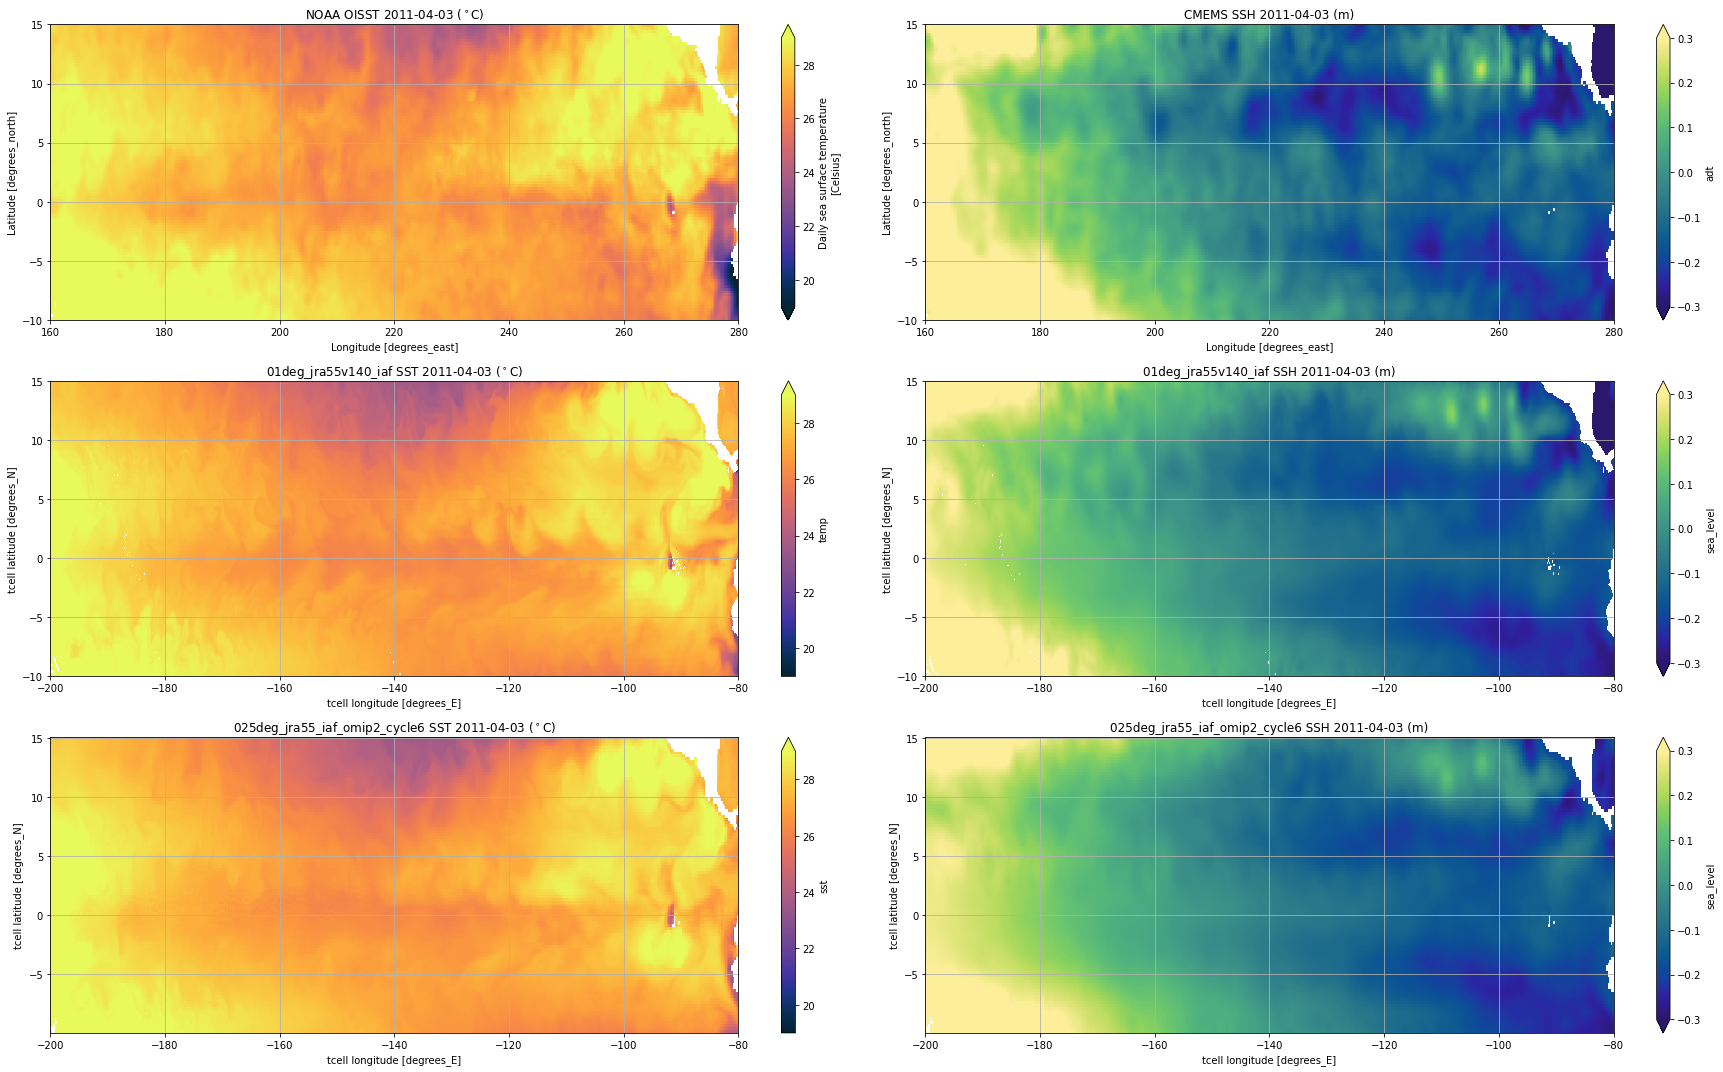

In [21]:
#dates = ['2010-11-01','2018-01-01','2011-11-01']
dates = ['2011-04-03']
#dates = ['2010-11-02','2010-11-03','2010-11-04','2010-11-05','2010-11-06','2010-11-07','2010-11-08','2010-11-09',
#        '2010-11-10','2010-11-11','2010-11-12','2010-11-13','2010-11-14','2010-11-15','2010-11-16','2010-11-17']

xr = -200.,-80.
yr = -10.,15.
tlims = 19.,29.
zlims = -0.3,0.3

for i, date in enumerate(dates):
    
    fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(25,15))

    # Load 01deg data:
    sst01 = cc.querying.getvar(exp01, 'temp',session, frequency='1 daily',start_time=date,end_time=date).isel(st_ocean=0)-273.15
    sst01 = sst01.sel(xt_ocean=slice(xr[0],xr[1])).sel(yt_ocean=slice(yr[0],yr[1])).sel(time=date,method='nearest')
    ssh01 = cc.querying.getvar(exp01, 'sea_level',session, frequency='1 daily',start_time=date,end_time=date)
    ssh01 = ssh01.sel(xt_ocean=slice(xr[0],xr[1])).sel(yt_ocean=slice(yr[0],yr[1])).sel(time=date,method='nearest')
    
    # Load 025deg data:
    sst025 = cc.querying.getvar(exp025, 'sst',session, frequency='1 daily',start_time=date,end_time=date)-273.15
    sst025 = sst025.sel(xt_ocean=slice(xr[0],xr[1])).sel(yt_ocean=slice(yr[0],yr[1])).sel(time=date,method='nearest')
    ssh025 = cc.querying.getvar(exp025, 'sea_level',session, frequency='1 daily',start_time=date,end_time=date)
    ssh025 = ssh025.sel(xt_ocean=slice(xr[0],xr[1])).sel(yt_ocean=slice(yr[0],yr[1])).sel(time=date,method='nearest')
    
    sst_obs = OISST.sst.sel(lon=slice(xr[0]+360.,xr[1]+360.)).sel(lat=slice(yr[0],yr[1])).sel(time=date)
    ssh_obs = CMEMS.adt.sel(longitude=slice(xr[0]+360.,xr[1]+360.)).sel(latitude=slice(yr[0],yr[1])).sel(time=date)
    
    # De-spatial mean the SSH data:
    ssh01 = ssh01 - ssh01.mean('xt_ocean').mean('yt_ocean')
    ssh025 = ssh025 - ssh025.mean('xt_ocean').mean('yt_ocean')
    ssh_obs = ssh_obs - ssh_obs.mean('longitude').mean('latitude')
    
    sst_obs.plot(ax=axes[0][0],vmin=tlims[0],vmax=tlims[1],cmap=cm.cm.thermal)
    ssh_obs.plot(ax=axes[0][1],vmin=zlims[0],vmax=zlims[1],cmap=cm.cm.haline)
    sst01.plot(ax=axes[1][0],vmin=tlims[0],vmax=tlims[1],cmap=cm.cm.thermal)
    ssh01.plot(ax=axes[1][1],vmin=zlims[0],vmax=zlims[1],cmap=cm.cm.haline)
    sst025.plot(ax=axes[2][0],vmin=tlims[0],vmax=tlims[1],cmap=cm.cm.thermal)
    ssh025.plot(ax=axes[2][1],vmin=zlims[0],vmax=zlims[1],cmap=cm.cm.haline)
    
    axes[0][0].set_title('NOAA OISST ' + date + ' ($^\circ$C)')
    axes[0][1].set_title('CMEMS SSH ' + date + ' (m)')
    axes[1][0].set_title(exp01 + ' SST ' + date + ' ($^\circ$C)')
    axes[1][1].set_title(exp01 + ' SSH ' + date + ' (m)')
    axes[2][0].set_title(exp025 + ' SST ' + date + ' ($^\circ$C)')
    axes[2][1].set_title(exp025 + ' SSH ' + date + ' (m)')
    axes[0][0].grid()
    axes[0][1].grid()
    axes[1][0].grid()
    axes[1][1].grid()
    axes[2][0].grid()
    axes[2][1].grid()
    plt.tight_layout()
    
    plt.savefig('SST_SSH_snapshot_025deg_01deg_satobs_' + date + '.png',dpi=150)

# Plot some SST hovmoeller plots:

distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

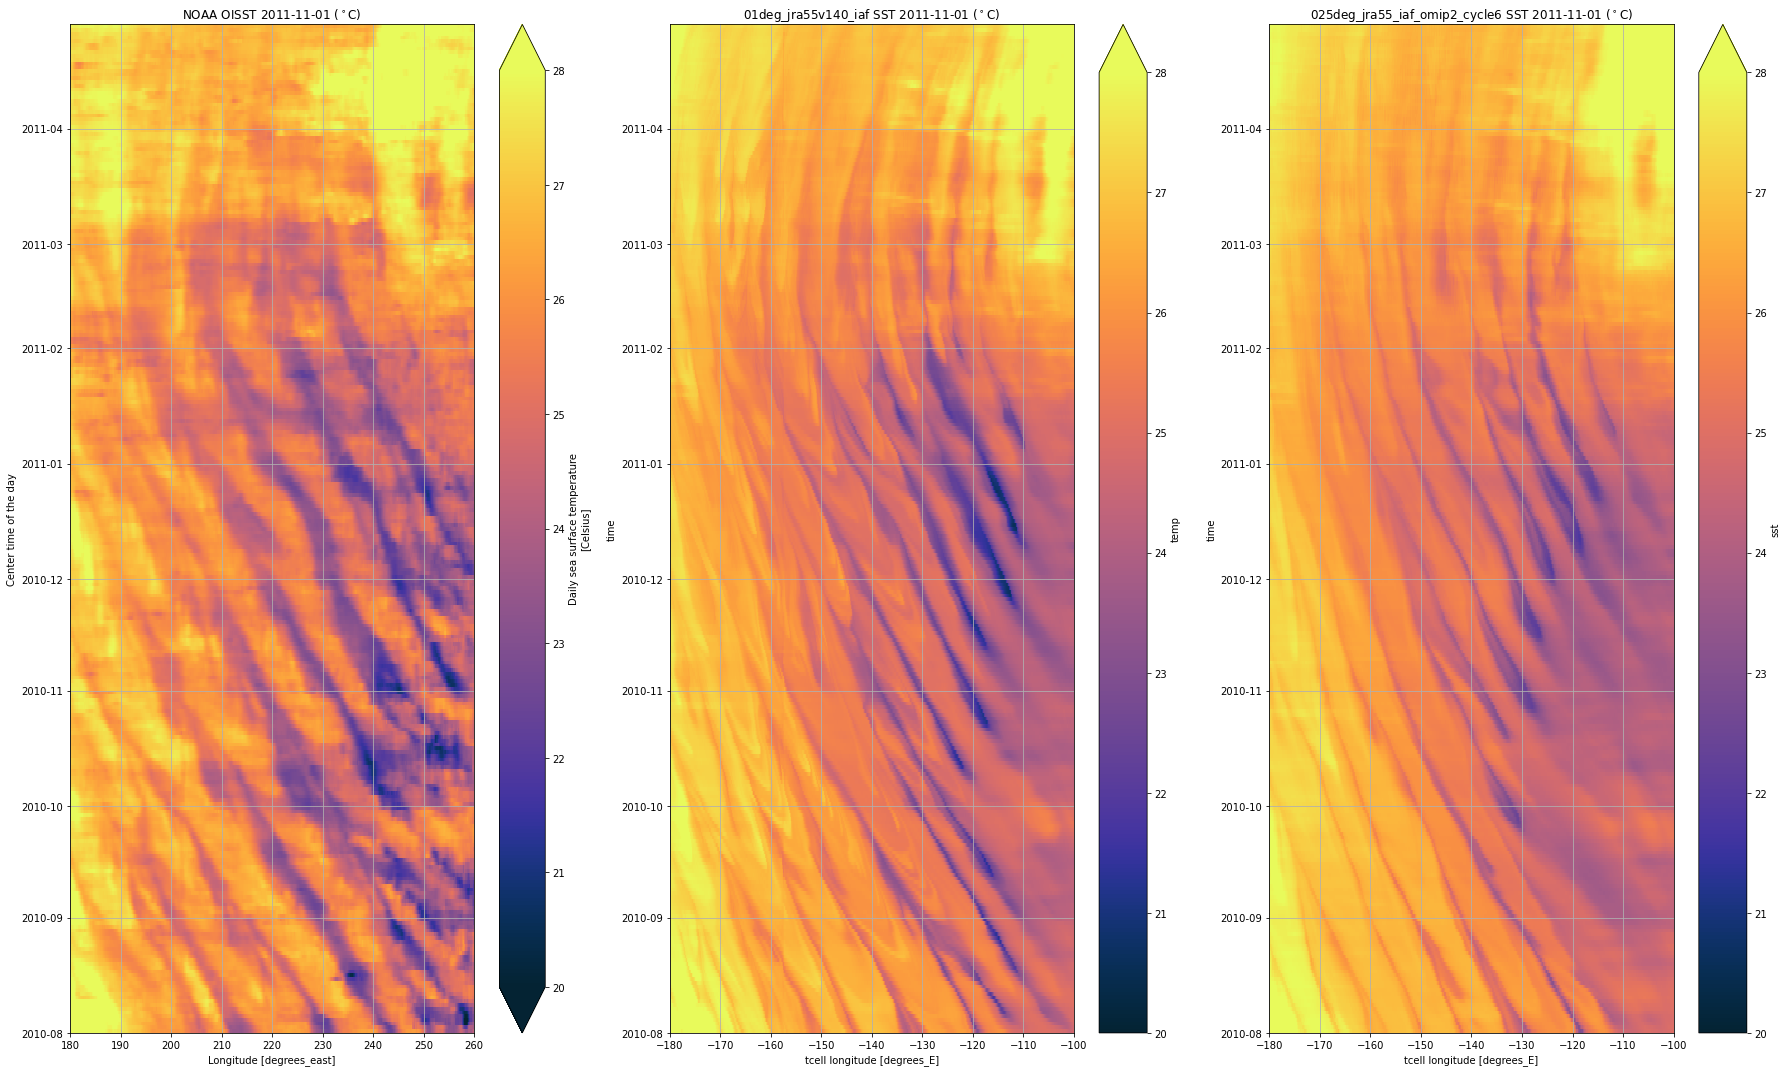

In [20]:
xr = -180.,-100.
yr = 2.
dater = '2010-08-01','2011-04-28'
tlims = 20.,28.

fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(25,15))

# Load 01deg data:
sst01 = cc.querying.getvar(exp01, 'temp',session, frequency='1 daily',start_time=dater[0],end_time=dater[1]).isel(st_ocean=0)-273.15
sst01 = sst01.sel(xt_ocean=slice(xr[0],xr[1])).sel(yt_ocean=yr,method='nearest').sel(time=slice(dater[0],dater[1]))

# Load 025deg data:
sst025 = cc.querying.getvar(exp025, 'sst',session, frequency='1 daily',start_time=dater[0],end_time=dater[1])-273.15
sst025 = sst025.sel(xt_ocean=slice(xr[0],xr[1])).sel(yt_ocean=yr,method='nearest').sel(time=slice(dater[0],dater[1]))

# Load obs data:
sst_obs = OISST.sst.sel(lon=slice(xr[0]+360.,xr[1]+360.)).sel(lat=yr,method='nearest').sel(time=slice(dater[0],dater[1]))

sst_obs.plot(ax=axes[0],vmin=tlims[0],vmax=tlims[1],cmap=cm.cm.thermal)
sst01.plot(ax=axes[1],vmin=tlims[0],vmax=tlims[1],cmap=cm.cm.thermal)
sst025.plot(ax=axes[2],vmin=tlims[0],vmax=tlims[1],cmap=cm.cm.thermal)

# Plot some example lines for speed:
#lines = [[[-120.,-140.],['2010-11-01','2010-12-23']],
#         [[-120.,-140.],['2010-10-11','2010-11-28']]]
#cols = ['r','b']
#for i,ln in enumerate(lines):
    #axes[0].plot([ln[0][0]+360.,ln[0][1]+360.],ln[1],'-'+cols[i])
    #axes[1].plot(ln[0],ln[1],'-'+cols[i])
    #axes[2].plot(ln[0],ln[1],'-'+cols[i])

axes[0].set_title('NOAA OISST ' + date + ' ($^\circ$C)')
axes[1].set_title(exp01 + ' SST ' + date + ' ($^\circ$C)')
axes[2].set_title(exp025 + ' SST ' + date + ' ($^\circ$C)')
axes[0].grid()
axes[1].grid()
axes[2].grid()
plt.tight_layout()

plt.savefig('SST_2010_Hovemoeller_2N.png',dpi=150)

## Longitude high-pass filtered variance comparison (ACCESS-OM2-01):

In [6]:
# Select regions for high-pass longitude filtered analysis:
ln_hp_filt = 12.0

xr = -170.,-100.
xrf = xr[0]-ln_hp_filt/2.,xr[1]+ln_hp_filt/2.
yr = -2.,10.
timer = '2009-01-01','2019-01-01'

sst = cc.querying.getvar(exp, 'temp',session, frequency='1 daily',start_time=timer[0],end_time=timer[1]).isel(st_ocean=0)-273.15
ssh = cc.querying.getvar(exp, 'sea_level',session, frequency='1 daily',start_time=timer[0],end_time=timer[1])
sst = sst.sel(xt_ocean=slice(xrf[0],xrf[1])).sel(yt_ocean=slice(yr[0],yr[1])).sel(time=slice(timer[0],timer[1]))
ssh = ssh.sel(xt_ocean=slice(xrf[0],xrf[1])).sel(yt_ocean=slice(yr[0],yr[1])).sel(time=slice(timer[0],timer[1]))
    
sst_obs = OISST.sst.sel(lon=slice(xrf[0]+360.,xrf[1]+360.)).sel(lat=slice(yr[0],yr[1])).sel(time=slice(timer[0],timer[1]))
ssh_obs = CMEMS.adt.sel(longitude=slice(xrf[0]+360.,xrf[1]+360.)).sel(latitude=slice(yr[0],yr[1])).sel(time=slice(timer[0],timer[1]))

# July-December only:
#def is_jd(month):
#    return (month >= 7)

#sst = sst.sel(time=is_jd(sst['time.month']))
#ssh = ssh.sel(time=is_jd(ssh['time.month']))
#sst_obs = sst_obs.sel(time=is_jd(sst_obs['time.month']))
#ssh_obs = ssh_obs.sel(time=is_jd(ssh_obs['time.month']))

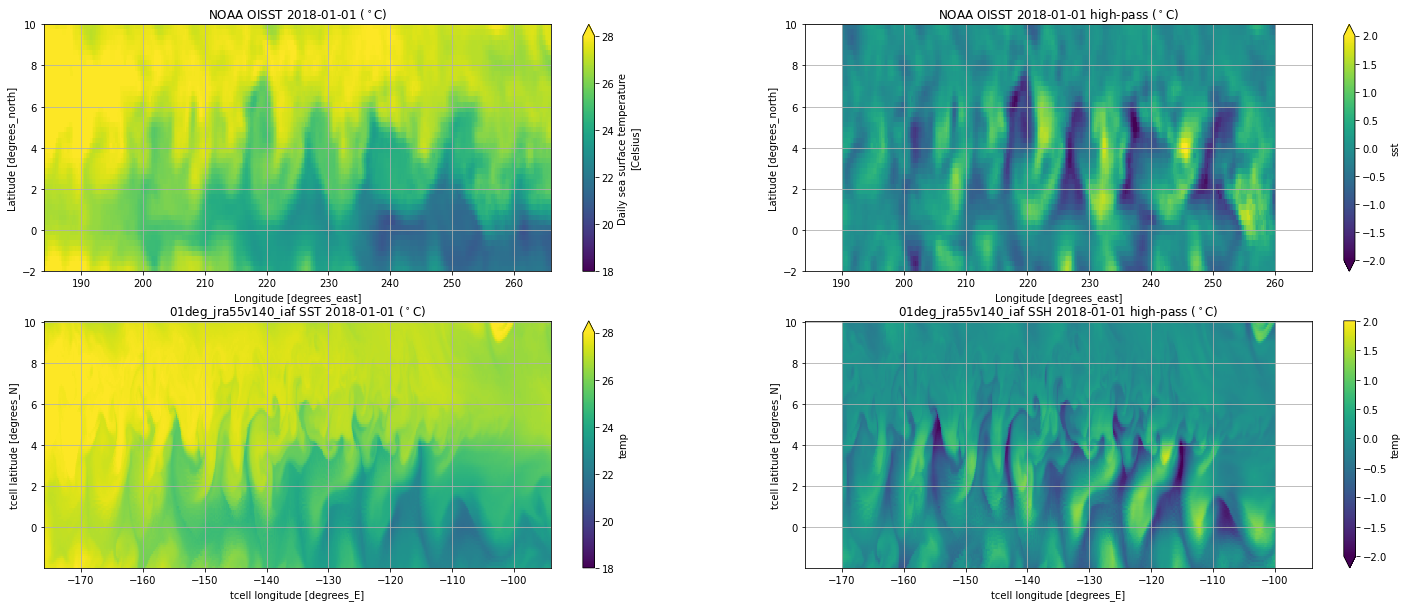

In [7]:
# Test plots at a single time:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(25,10))
date = '2018-01-01'

sst_obs_test = sst_obs.sel(time=date)
sst_obs_test.plot(ax=axes[0][0],vmin=18.,vmax=28.)
sst_obs_test_hp = (sst_obs_test-sst_obs_test.rolling(lon=int(ln_hp_filt/(1./4.)),center=True).mean())
sst_obs_test_hp.plot(ax=axes[0][1],vmin=-2.,vmax=2.)

sst_test = sst.sel(time=date)
sst_test.plot(ax=axes[1][0],vmin=18.,vmax=28.)
sst_test_hp = (sst_test-sst_test.rolling(xt_ocean=int(ln_hp_filt/(1./10.)),center=True).mean())
sst_test_hp.plot(ax=axes[1][1],vmin=-2.,vmax=2.)
    
axes[0][0].set_title('NOAA OISST ' + date + ' ($^\circ$C)')
axes[0][1].set_title('NOAA OISST ' + date + ' high-pass ($^\circ$C)')
axes[1][0].set_title(exp + ' SST ' + date + ' ($^\circ$C)')
axes[1][1].set_title(exp + ' SSH ' + date + ' high-pass ($^\circ$C)')
axes[0][0].grid()
axes[0][1].grid()
axes[1][0].grid()
axes[1][1].grid()

In [ ]:
# Do high-pass filtering:
sst_hp = (sst-sst.rolling(xt_ocean=int(ln_hp_filt/(1./10.)),center=True).mean())
sst_hp_std = sst_hp.std('time')
sst_hp_std.load()

In [ ]:
ssh_hp = (ssh-ssh.rolling(xt_ocean=int(ln_hp_filt/(1./10.)),center=True).mean())
ssh_hp_std = ssh_hp.std('time')
ssh_hp_std.load()

In [ ]:
ssh_obs_hp = (ssh_obs-ssh_obs.rolling(longitude=int(ln_hp_filt/(1./4.)),center=True).mean())
ssh_obs_hp_std = ssh_obs_hp.std('time')
ssh_obs_hp_std.load()

In [ ]:
sst_obs_hp = (sst_obs-sst_obs.rolling(lon=int(ln_hp_filt/(1./4.)),center=True).mean())
sst_obs_hp_std = sst_obs_hp.std('time').isel(zlev=0)
sst_obs_hp_std.load()

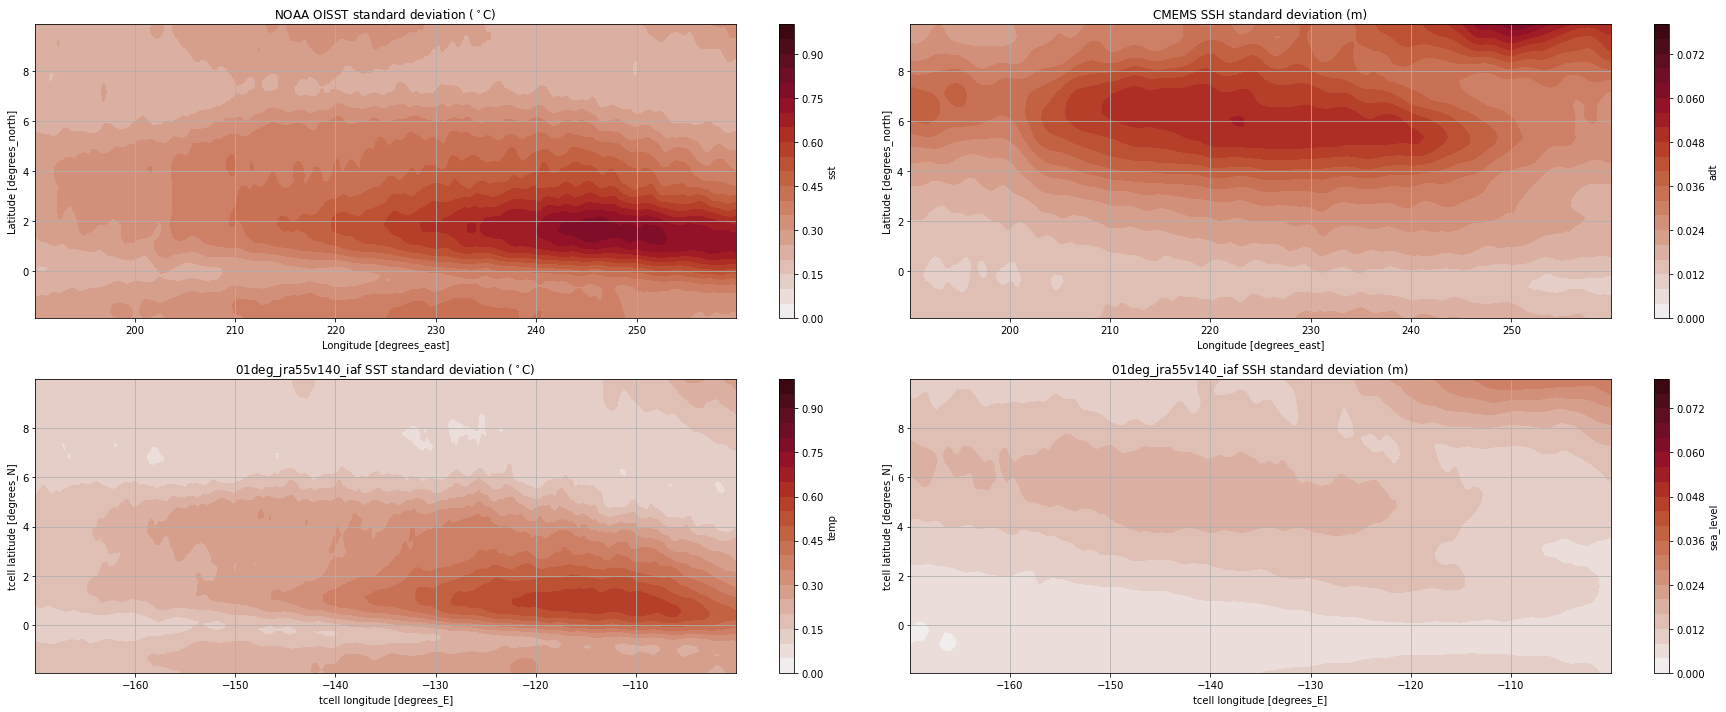

In [19]:
tlims = 0.,1.
zlims = 0.,0.08
tsp = tlims[1]/20.
zsp = zlims[1]/20.

# Do the plotting:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(25,10))
sst_obs_hp_std.sel(lon=slice(xr[0]+360.,xr[1]+360.)).plot.contourf(ax=axes[0][0],levels=np.arange(tlims[0],tlims[1]+tsp,tsp),cmap=cm.cm.amp)
ssh_obs_hp_std.sel(longitude=slice(xr[0]+360.,xr[1]+360.)).plot.contourf(ax=axes[0][1],levels=np.arange(zlims[0],zlims[1]+zsp,zsp),cmap=cm.cm.amp)
sst_hp_std.sel(xt_ocean=slice(xr[0],xr[1])).plot.contourf(ax=axes[1][0],levels=np.arange(tlims[0],tlims[1]+tsp,tsp),cmap=cm.cm.amp)
ssh_hp_std.sel(xt_ocean=slice(xr[0],xr[1])).plot.contourf(ax=axes[1][1],levels=np.arange(zlims[0],zlims[1]+zsp,zsp),cmap=cm.cm.amp)
    
axes[0][0].set_title('NOAA OISST standard deviation ($^\circ$C)')
axes[0][1].set_title('CMEMS SSH standard deviation (m)')
axes[1][0].set_title(exp + ' SST standard deviation ($^\circ$C)')
axes[1][1].set_title(exp + ' SSH standard deviation (m)')
axes[0][0].grid()
axes[0][1].grid()
axes[1][0].grid()
axes[1][1].grid()
plt.tight_layout()
plt.savefig('SSH_SST_FiltPlot.png',dpi=300)

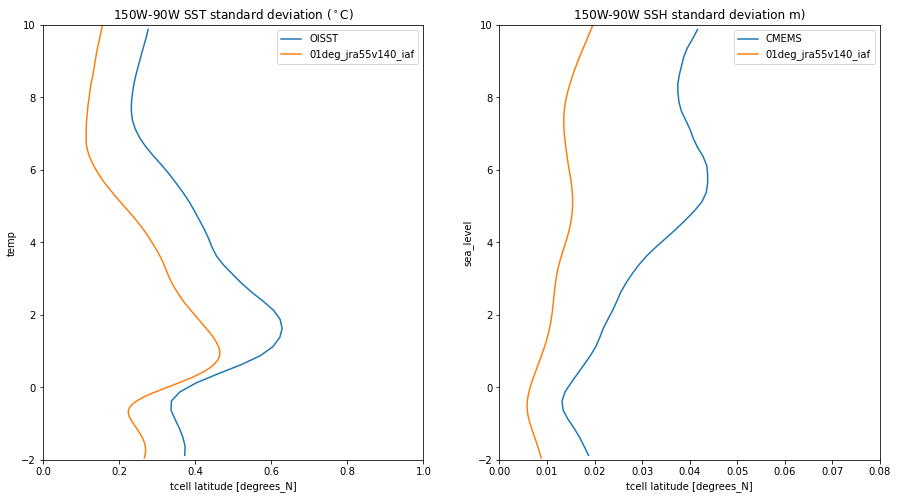

In [31]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
reg = -150.,-90.

sst_obs_hp_std.sel(lon=slice(reg[0]+360.,reg[1]+360.)).mean('lon').plot(ax=axes[0],label='OISST')
ssh_obs_hp_std.sel(longitude=slice(reg[0]+360.,reg[1]+360.)).mean('longitude').plot(ax=axes[1],label='CMEMS')
sst_hp_std.sel(xt_ocean=slice(reg[0],reg[1])).mean('xt_ocean').plot(ax=axes[0],label=exp)
ssh_hp_std.sel(xt_ocean=slice(reg[0],reg[1])).mean('xt_ocean').plot(ax=axes[1],label=exp)

for ax in axes:
    for obj in ax.lines:   
        newx = obj.get_ydata()
        newy = obj.get_xdata()

# set new x- and y- data for the line
        obj.set_xdata(newx)
        obj.set_ydata(newy)

axes[0].set_xlim([0.,1.])
axes[0].set_ylim([-2.,10.])
axes[1].set_xlim([0.,0.08])
axes[1].set_ylim([-2.,10.])
axes[0].set_title('150W-90W SST standard deviation ($^\circ$C)')
axes[0].legend()
axes[1].set_title('150W-90W SSH standard deviation m)')
axes[1].legend()

plt.savefig('SSH_SST_FiltPlot_LonAvg.png',dpi=300)

## Longitude high-pass filtered variance comparison (Gulf Stream check):

In [13]:
# Select regions for high-pass longitude filtered analysis:
ln_hp_filt = 12.0

xr = -70.,-55.
xrf = xr[0]-ln_hp_filt/2.,xr[1]+ln_hp_filt/2.
yr = 35.,45.
timer = '2009-01-01','2019-01-01'

sst = cc.querying.getvar(exp, 'temp',session, frequency='1 daily',start_time=timer[0],end_time=timer[1]).isel(st_ocean=0)-273.15
ssh = cc.querying.getvar(exp, 'sea_level',session, frequency='1 daily',start_time=timer[0],end_time=timer[1])
sst = sst.sel(xt_ocean=slice(xrf[0],xrf[1])).sel(yt_ocean=slice(yr[0],yr[1])).sel(time=slice(timer[0],timer[1]))
ssh = ssh.sel(xt_ocean=slice(xrf[0],xrf[1])).sel(yt_ocean=slice(yr[0],yr[1])).sel(time=slice(timer[0],timer[1]))
    
sst_obs = OISST.sst.sel(lon=slice(xrf[0]+360.,xrf[1]+360.)).sel(lat=slice(yr[0],yr[1])).sel(time=slice(timer[0],timer[1]))
ssh_obs = CMEMS.adt.sel(longitude=slice(xrf[0]+360.,xrf[1]+360.)).sel(latitude=slice(yr[0],yr[1])).sel(time=slice(timer[0],timer[1]))

# July-December only:
#def is_jd(month):
#    return (month >= 7)

#sst = sst.sel(time=is_jd(sst['time.month']))
#ssh = ssh.sel(time=is_jd(ssh['time.month']))
#sst_obs = sst_obs.sel(time=is_jd(sst_obs['time.month']))
#ssh_obs = ssh_obs.sel(time=is_jd(ssh_obs['time.month']))

In [ ]:
# Do high-pass filtering:
sst_hp = (sst-sst.rolling(xt_ocean=int(ln_hp_filt/(1./10.)),center=True).mean())
sst_hp_std = sst_hp.std('time')
sst_hp_std.load()

ssh_hp = (ssh-ssh.rolling(xt_ocean=int(ln_hp_filt/(1./10.)),center=True).mean())
ssh_hp_std = ssh_hp.std('time')
ssh_hp_std.load()

ssh_obs_hp = (ssh_obs-ssh_obs.rolling(longitude=int(ln_hp_filt/(1./4.)),center=True).mean())
ssh_obs_hp_std = ssh_obs_hp.std('time')
ssh_obs_hp_std.load()

sst_obs_hp = (sst_obs-sst_obs.rolling(lon=int(ln_hp_filt/(1./4.)),center=True).mean())
sst_obs_hp_std = sst_obs_hp.std('time').isel(zlev=0)
sst_obs_hp_std.load()

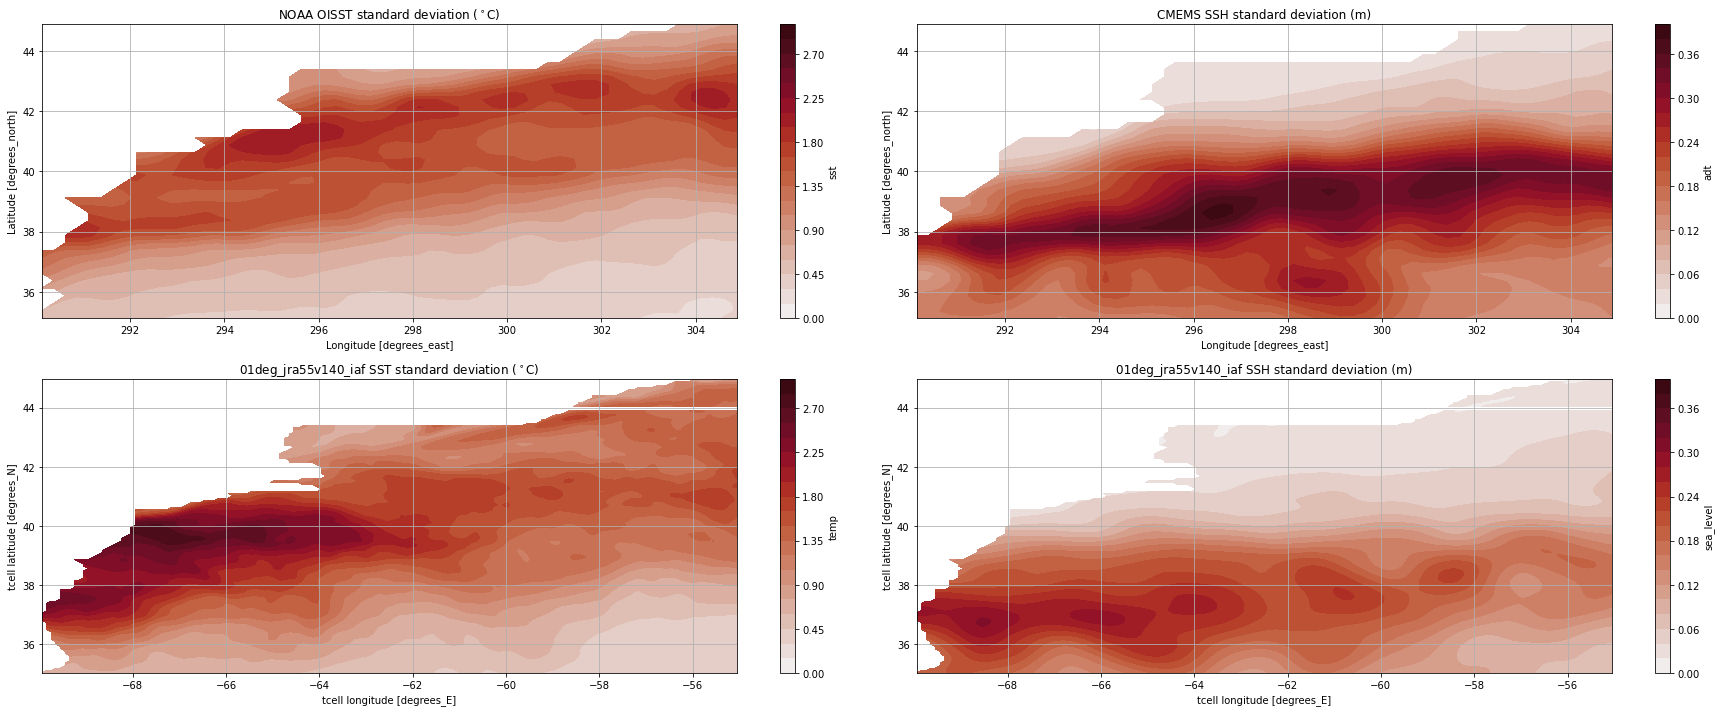

In [15]:
tlims = 0.,3.
zlims = 0.,0.4
tsp = tlims[1]/20.
zsp = zlims[1]/20.

# Do the plotting:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(25,10))
sst_obs_hp_std.sel(lon=slice(xr[0]+360.,xr[1]+360.)).plot.contourf(ax=axes[0][0],levels=np.arange(tlims[0],tlims[1]+tsp,tsp),cmap=cm.cm.amp)
ssh_obs_hp_std.sel(longitude=slice(xr[0]+360.,xr[1]+360.)).plot.contourf(ax=axes[0][1],levels=np.arange(zlims[0],zlims[1]+zsp,zsp),cmap=cm.cm.amp)
sst_hp_std.sel(xt_ocean=slice(xr[0],xr[1])).plot.contourf(ax=axes[1][0],levels=np.arange(tlims[0],tlims[1]+tsp,tsp),cmap=cm.cm.amp)
ssh_hp_std.sel(xt_ocean=slice(xr[0],xr[1])).plot.contourf(ax=axes[1][1],levels=np.arange(zlims[0],zlims[1]+zsp,zsp),cmap=cm.cm.amp)
    
axes[0][0].set_title('NOAA OISST standard deviation ($^\circ$C)')
axes[0][1].set_title('CMEMS SSH standard deviation (m)')
axes[1][0].set_title(exp + ' SST standard deviation ($^\circ$C)')
axes[1][1].set_title(exp + ' SSH standard deviation (m)')
axes[0][0].grid()
axes[0][1].grid()
axes[1][0].grid()
axes[1][1].grid()
plt.tight_layout()
plt.savefig('SSH_SST_FiltPlot_GulfStreamNorth.png',dpi=300)

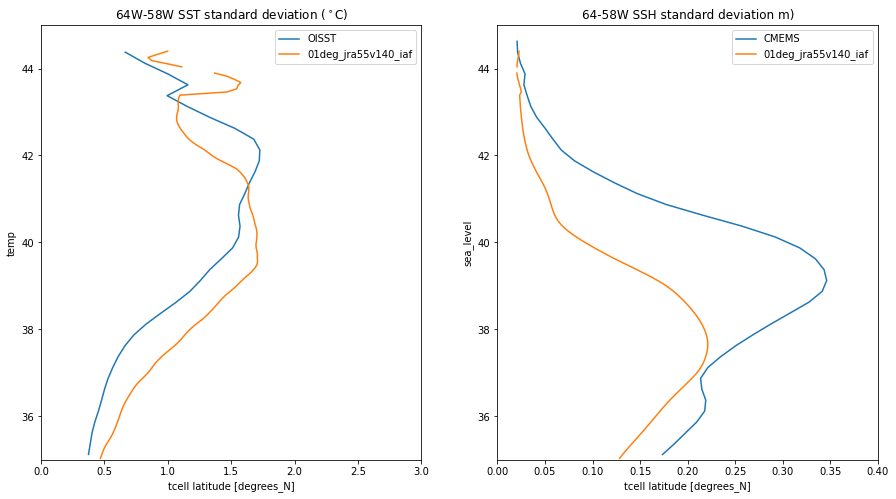

In [19]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
reg = -64.,-58.

sst_obs_hp_std.sel(lon=slice(reg[0]+360.,reg[1]+360.)).mean('lon').plot(ax=axes[0],label='OISST')
ssh_obs_hp_std.sel(longitude=slice(reg[0]+360.,reg[1]+360.)).mean('longitude').plot(ax=axes[1],label='CMEMS')
sst_hp_std.sel(xt_ocean=slice(reg[0],reg[1])).mean('xt_ocean').plot(ax=axes[0],label=exp)
ssh_hp_std.sel(xt_ocean=slice(reg[0],reg[1])).mean('xt_ocean').plot(ax=axes[1],label=exp)

for ax in axes:
    for obj in ax.lines:   
        newx = obj.get_ydata()
        newy = obj.get_xdata()

# set new x- and y- data for the line
        obj.set_xdata(newx)
        obj.set_ydata(newy)

axes[0].set_xlim([0.,3.])
axes[0].set_ylim([35.,45.])
axes[1].set_xlim([0.,0.4])
axes[1].set_ylim([35.,45.])
axes[0].set_title('64W-58W SST standard deviation ($^\circ$C)')
axes[0].legend()
axes[1].set_title('64-58W SSH standard deviation m)')
axes[1].legend()

plt.savefig('SSH_SST_FiltPlot_GulfStreamNorth_LonAvg.png',dpi=300)

## Longitude high-pass filtered variance comparison (ACCESS-OM2-025):

In [36]:
# Select regions for high-pass longitude filtered analysis:
ln_hp_filt = 12.0

xr = -170.,-100.
xrf = xr[0]-ln_hp_filt/2.,xr[1]+ln_hp_filt/2.
yr = -2.,10.
timer = '2009-01-01','2019-01-01'

sst = cc.querying.getvar(exp, 'sst',session, frequency='1 daily',start_time=timer[0],end_time=timer[1])-273.15
ssh = cc.querying.getvar(exp, 'sea_level',session, frequency='1 daily',start_time=timer[0],end_time=timer[1])
sst = sst.sel(xt_ocean=slice(xrf[0],xrf[1])).sel(yt_ocean=slice(yr[0],yr[1])).sel(time=slice(timer[0],timer[1]))
ssh = ssh.sel(xt_ocean=slice(xrf[0],xrf[1])).sel(yt_ocean=slice(yr[0],yr[1])).sel(time=slice(timer[0],timer[1]))
    
sst_obs = OISST.sst.sel(lon=slice(xrf[0]+360.,xrf[1]+360.)).sel(lat=slice(yr[0],yr[1])).sel(time=slice(timer[0],timer[1]))
ssh_obs = CMEMS.adt.sel(longitude=slice(xrf[0]+360.,xrf[1]+360.)).sel(latitude=slice(yr[0],yr[1])).sel(time=slice(timer[0],timer[1]))

# July-December only:
#def is_jd(month):
#    return (month >= 7)

#sst = sst.sel(time=is_jd(sst['time.month']))
#ssh = ssh.sel(time=is_jd(ssh['time.month']))
#sst_obs = sst_obs.sel(time=is_jd(sst_obs['time.month']))
#ssh_obs = ssh_obs.sel(time=is_jd(ssh_obs['time.month']))

In [ ]:
# Do high-pass filtering:
sst_hp = (sst-sst.rolling(xt_ocean=int(ln_hp_filt/(1./4.)),center=True).mean())
sst_hp_std = sst_hp.std('time')
sst_hp_std.load()

ssh_hp = (ssh-ssh.rolling(xt_ocean=int(ln_hp_filt/(1./4.)),center=True).mean())
ssh_hp_std = ssh_hp.std('time')
ssh_hp_std.load()

ssh_obs_hp = (ssh_obs-ssh_obs.rolling(longitude=int(ln_hp_filt/(1./4.)),center=True).mean())
ssh_obs_hp_std = ssh_obs_hp.std('time')
ssh_obs_hp_std.load()

sst_obs_hp = (sst_obs-sst_obs.rolling(lon=int(ln_hp_filt/(1./4.)),center=True).mean())
sst_obs_hp_std = sst_obs_hp.std('time').isel(zlev=0)
sst_obs_hp_std.load()

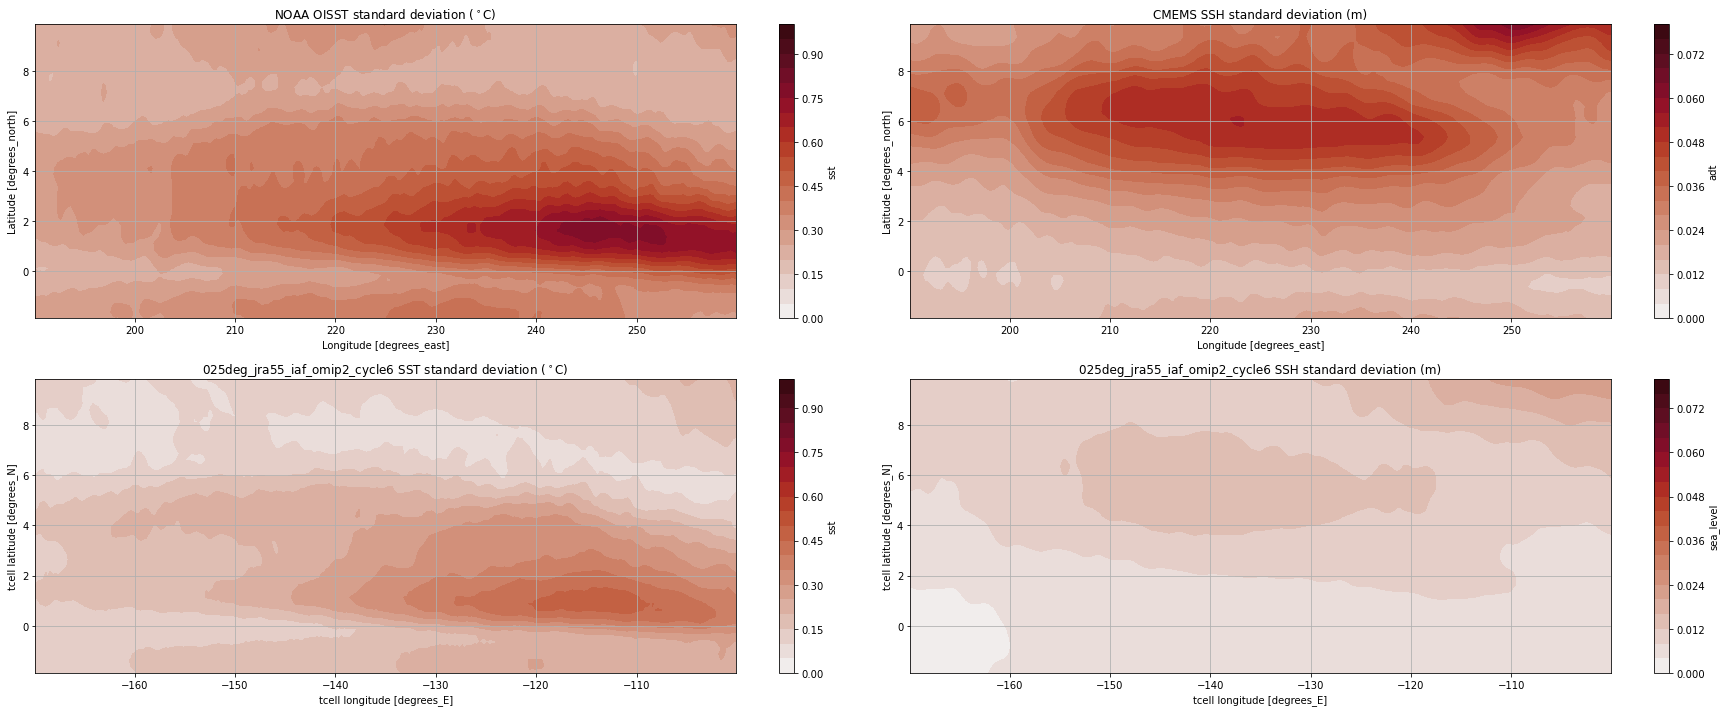

In [38]:
tlims = 0.,1.
zlims = 0.,0.08
tsp = tlims[1]/20.
zsp = zlims[1]/20.

# Do the plotting:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(25,10))
sst_obs_hp_std.sel(lon=slice(xr[0]+360.,xr[1]+360.)).plot.contourf(ax=axes[0][0],levels=np.arange(tlims[0],tlims[1]+tsp,tsp),cmap=cm.cm.amp)
ssh_obs_hp_std.sel(longitude=slice(xr[0]+360.,xr[1]+360.)).plot.contourf(ax=axes[0][1],levels=np.arange(zlims[0],zlims[1]+zsp,zsp),cmap=cm.cm.amp)
sst_hp_std.sel(xt_ocean=slice(xr[0],xr[1])).plot.contourf(ax=axes[1][0],levels=np.arange(tlims[0],tlims[1]+tsp,tsp),cmap=cm.cm.amp)
ssh_hp_std.sel(xt_ocean=slice(xr[0],xr[1])).plot.contourf(ax=axes[1][1],levels=np.arange(zlims[0],zlims[1]+zsp,zsp),cmap=cm.cm.amp)
    
axes[0][0].set_title('NOAA OISST standard deviation ($^\circ$C)')
axes[0][1].set_title('CMEMS SSH standard deviation (m)')
axes[1][0].set_title(exp + ' SST standard deviation ($^\circ$C)')
axes[1][1].set_title(exp + ' SSH standard deviation (m)')
axes[0][0].grid()
axes[0][1].grid()
axes[1][0].grid()
axes[1][1].grid()
plt.tight_layout()
plt.savefig('SSH_SST_FiltPlot_025deg.png',dpi=300)

## Summary of results so far:

- TIWs in both ACCESS-OM2-025 and ACCESS-OM2-01 seems to have shorter wavelengths and do not penetrate as far north as in the observations (e.g. 2010-11-07 there seem to be 5 wavelengths from 120 to 160W in ACCESS-OM2, compared to 3 in the SST and SSH observations). 
- The magnitude of the TIV SSH anomalies are much weaker than in the observations (factor of 2 at least).
- ACCESS-OM2-01 shows significant submesoscale variability and instabilities along the TIW fronts, which seem to result in less northward penetration of cold water than in ACCESS-OM2-025.
- The Hovmoeller plot shows similar features: With much wider cold tongues and less TIWs/season in the observations than the models. The propagation speed also looks a bit faster.

Next steps:
- Look at the zonal and meridional velocity structures in comparison to observations (SODA). Perhaps for simplicity focus on the 2010-2011 season?

# Compare zonal/meridional velocity to SODA (start just at 140W):

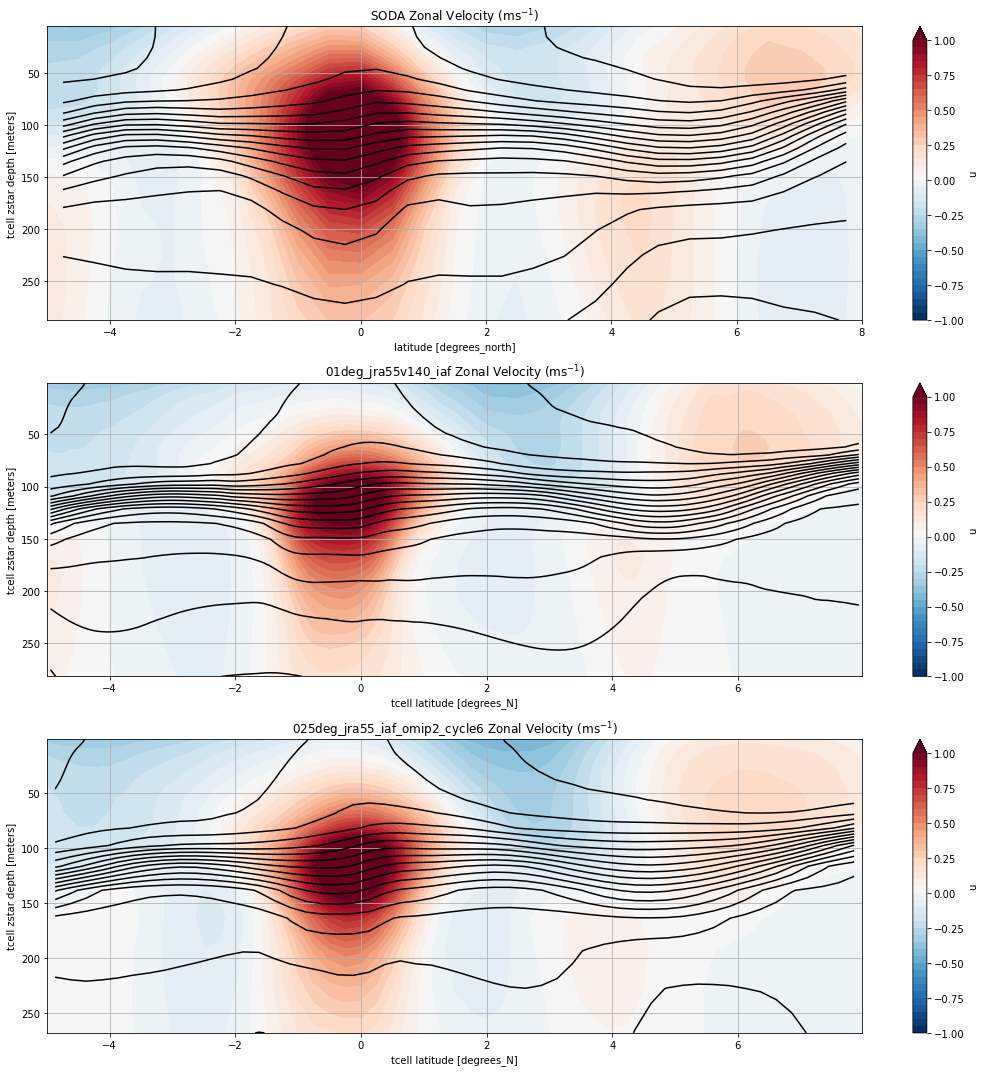

In [75]:
lon = -140.
lats = -5., 8.
deps = 0.,300.
dates = '2010-07-01','2011-07-01'

u_obs = SODA.u.sel(time=slice(dates[0],dates[1])).sel(xu_ocean=lon+360.,method='nearest').sel(yu_ocean=slice(lats[0],lats[1])).sel(st_ocean=slice(deps[0],deps[1])).mean('time')
u01 = cc.querying.getvar(exp01, 'u',session, frequency='1 monthly',start_time=dates[0],end_time=dates[1])
u01 = u01.sel(time=slice(dates[0],dates[1])).sel(xu_ocean=lon,method='nearest').sel(yu_ocean=slice(lats[0],lats[1])).sel(st_ocean=slice(deps[0],deps[1])).mean('time')
u025 = cc.querying.getvar(exp025, 'u',session, frequency='1 monthly',start_time=dates[0],end_time=dates[1])
u025 = u025.sel(time=slice(dates[0],dates[1])).sel(xu_ocean=lon,method='nearest').sel(yu_ocean=slice(lats[0],lats[1])).sel(st_ocean=slice(deps[0],deps[1])).mean('time')

temp_obs = SODA.temp.sel(time=slice(dates[0],dates[1])).sel(xt_ocean=lon+360.,method='nearest').sel(yt_ocean=slice(lats[0],lats[1])).sel(st_ocean=slice(deps[0],deps[1])).mean('time')
temp01 = cc.querying.getvar(exp01, 'temp',session, frequency='1 monthly',start_time=dates[0],end_time=dates[1])
temp01 = temp01.sel(time=slice(dates[0],dates[1])).sel(xt_ocean=lon,method='nearest').sel(yt_ocean=slice(lats[0],lats[1])).sel(st_ocean=slice(deps[0],deps[1])).mean('time')-273.15
temp025 = cc.querying.getvar(exp025, 'temp',session, frequency='1 monthly',start_time=dates[0],end_time=dates[1])
temp025 = temp025.sel(time=slice(dates[0],dates[1])).sel(xt_ocean=lon,method='nearest').sel(yt_ocean=slice(lats[0],lats[1])).sel(st_ocean=slice(deps[0],deps[1])).mean('time')-273.15


fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(15,15))
levs = np.arange(-1.,1.05,0.05)
u_obs.plot.contourf(ax=axes[0],levels=levs,cmap='RdBu_r')
u01.plot.contourf(ax=axes[1],levels=levs,cmap='RdBu_r')
u025.plot.contourf(ax=axes[2],levels=levs,cmap='RdBu_r')

temp_obs.plot.contour(ax=axes[0],levels=np.arange(0.,30.,1.),colors='k')
temp01.plot.contour(ax=axes[1],levels=np.arange(0.,30.,1.),colors='k')
temp025.plot.contour(ax=axes[2],levels=np.arange(0.,30.,1.),colors='k')

axes[0].set_title('SODA Zonal Velocity (ms$^{-1}$)')
axes[1].set_title(exp01 + ' Zonal Velocity (ms$^{-1}$)')
axes[2].set_title(exp025 + ' Zonal Velocity (ms$^{-1}$)')
axes[0].grid()
axes[1].grid()
axes[2].grid()
axes[0].invert_yaxis()
axes[1].invert_yaxis()
axes[2].invert_yaxis()
plt.tight_layout()
#plt.savefig('SSH_SST_FiltPlot_025deg.png',dpi=300)

# Compare surface meridional profiles:

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

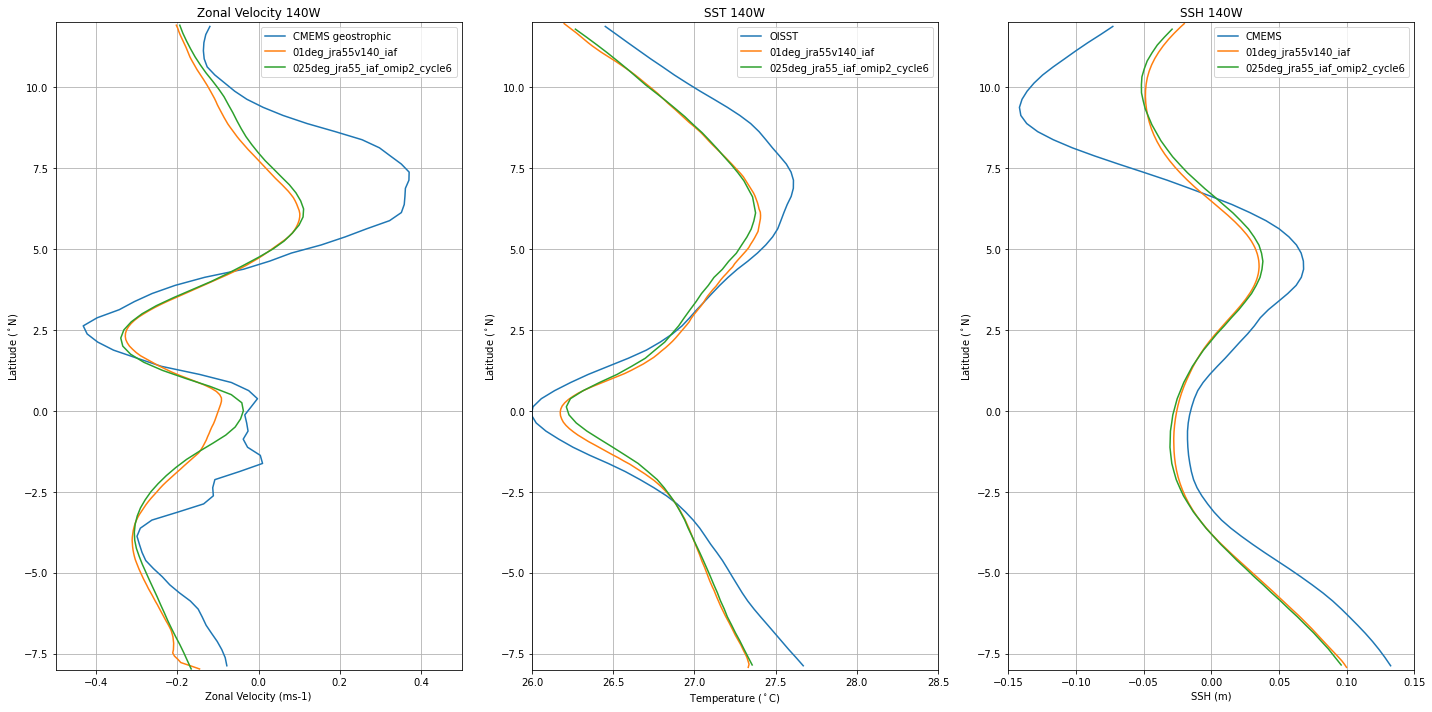

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [74]:
lon = -140.
lats = -8., 12.
deps = 0.
#dates = '2010-07-01','2011-07-01'
dates = '2000-01-01','2017-01-01'

#u_obs = SODA.u.sel(time=slice(dates[0],dates[1])).sel(xu_ocean=lon+360.,method='nearest').sel(yu_ocean=slice(lats[0],lats[1])).sel(st_ocean=deps,method='nearest').mean('time')
ugeo_obs = CMEMS.ugos.sel(time=slice(dates[0],dates[1])).sel(longitude=lon+360.,method='nearest').sel(latitude=slice(lats[0],lats[1])).mean('time')
u01 = cc.querying.getvar(exp01, 'u',session, frequency='1 monthly',start_time=dates[0],end_time=dates[1])
u01 = u01.sel(time=slice(dates[0],dates[1])).sel(xu_ocean=lon,method='nearest').sel(yu_ocean=slice(lats[0],lats[1])).sel(st_ocean=deps,method='nearest').mean('time')
u025 = cc.querying.getvar(exp025, 'u',session, frequency='1 monthly',start_time=dates[0],end_time=dates[1])
u025 = u025.sel(time=slice(dates[0],dates[1])).sel(xu_ocean=lon,method='nearest').sel(yu_ocean=slice(lats[0],lats[1])).sel(st_ocean=deps,method='nearest').mean('time')

#temp_soda = SODA.temp.sel(time=slice(dates[0],dates[1])).sel(xt_ocean=lon+360.,method='nearest').sel(yt_ocean=slice(lats[0],lats[1])).sel(st_ocean=deps,method='nearest').mean('time')
temp_oisst = OISST.sst.sel(time=slice(dates[0],dates[1])).sel(lon=lon+360.,method='nearest').sel(lat=slice(lats[0],lats[1])).mean('time')
temp01 = cc.querying.getvar(exp01, 'temp',session, frequency='1 monthly',start_time=dates[0],end_time=dates[1])
temp01 = temp01.sel(time=slice(dates[0],dates[1])).sel(xt_ocean=lon,method='nearest').sel(yt_ocean=slice(lats[0],lats[1])).sel(st_ocean=deps,method='nearest').mean('time')-273.15
temp025 = cc.querying.getvar(exp025, 'temp',session, frequency='1 monthly',start_time=dates[0],end_time=dates[1])
temp025 = temp025.sel(time=slice(dates[0],dates[1])).sel(xt_ocean=lon,method='nearest').sel(yt_ocean=slice(lats[0],lats[1])).sel(st_ocean=deps,method='nearest').mean('time')-273.15

ssh_obs = CMEMS.adt.sel(time=slice(dates[0],dates[1])).sel(longitude=lon+360.,method='nearest').sel(latitude=slice(lats[0],lats[1])).mean('time')
#ssh_soda = SODA.ssh.sel(time=slice(dates[0],dates[1])).sel(xt_ocean=lon+360.,method='nearest').sel(yt_ocean=slice(lats[0],lats[1])).mean('time')
ssh01 = cc.querying.getvar(exp01, 'sea_level',session, frequency='1 monthly',start_time=dates[0],end_time=dates[1])
ssh01 = ssh01.sel(time=slice(dates[0],dates[1])).sel(xt_ocean=lon,method='nearest').sel(yt_ocean=slice(lats[0],lats[1])).mean('time')
ssh025 = cc.querying.getvar(exp025, 'sea_level',session, frequency='1 monthly',start_time=dates[0],end_time=dates[1])
ssh025 = ssh025.sel(time=slice(dates[0],dates[1])).sel(xt_ocean=lon,method='nearest').sel(yt_ocean=slice(lats[0],lats[1])).mean('time')

# subtract mean:
ssh01=ssh01-ssh01.mean('yt_ocean')
ssh025=ssh025-ssh025.mean('yt_ocean')
ssh_obs=ssh_obs-ssh_obs.mean('latitude')
#ssh_soda=ssh_soda-ssh_soda.mean('yt_ocean')

fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,10))

#u_obs.plot(ax=axes[0],label='SODA')
ugeo_obs.plot(ax=axes[0],label='CMEMS geostrophic')
u01.plot(ax=axes[0],label=exp01)
u025.plot(ax=axes[0],label=exp025)

#temp_soda.plot(ax=axes[1],label='SODA')
temp_oisst.plot(ax=axes[1],label='OISST')
temp01.plot(ax=axes[1],label=exp01)
temp025.plot(ax=axes[1],label=exp025)

#ssh_soda.plot(ax=axes[2],label='SODA')
ssh_obs.plot(ax=axes[2],label='CMEMS')
ssh01.plot(ax=axes[2],label=exp01)
ssh025.plot(ax=axes[2],label=exp025)

for ax in axes:
    for obj in ax.lines:   
        newx = obj.get_ydata()
        newy = obj.get_xdata()
        obj.set_xdata(newx)
        obj.set_ydata(newy)

axes[0].set_title('Zonal Velocity 140W')
axes[1].set_title('SST 140W')
axes[2].set_title('SSH 140W')
axes[0].grid()
axes[1].grid()
axes[2].grid()
axes[0].legend()
axes[0].set_xlim([-0.5,0.5])
axes[0].set_ylim([lats[0],lats[1]])
axes[1].set_xlim([26.,28.5])
axes[1].set_ylim([lats[0],lats[1]])
axes[1].legend()
axes[2].set_xlim([-0.15,0.15])
axes[2].set_ylim([lats[0],lats[1]])
axes[2].legend()

axes[0].set_xlabel('Zonal Velocity (ms-1)')
axes[0].set_ylabel('Latitude ($^\circ$N)')
axes[1].set_xlabel('Temperature ($^\circ$C)')
axes[1].set_ylabel('Latitude ($^\circ$N)')
axes[2].set_xlabel('SSH (m)')
axes[2].set_ylabel('Latitude ($^\circ$N)')

#axes[0].invert_yaxis()
#axes[1].invert_yaxis()
plt.tight_layout()
plt.savefig('SSH_SST_u_140W_2000-2017.png',dpi=100)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, 

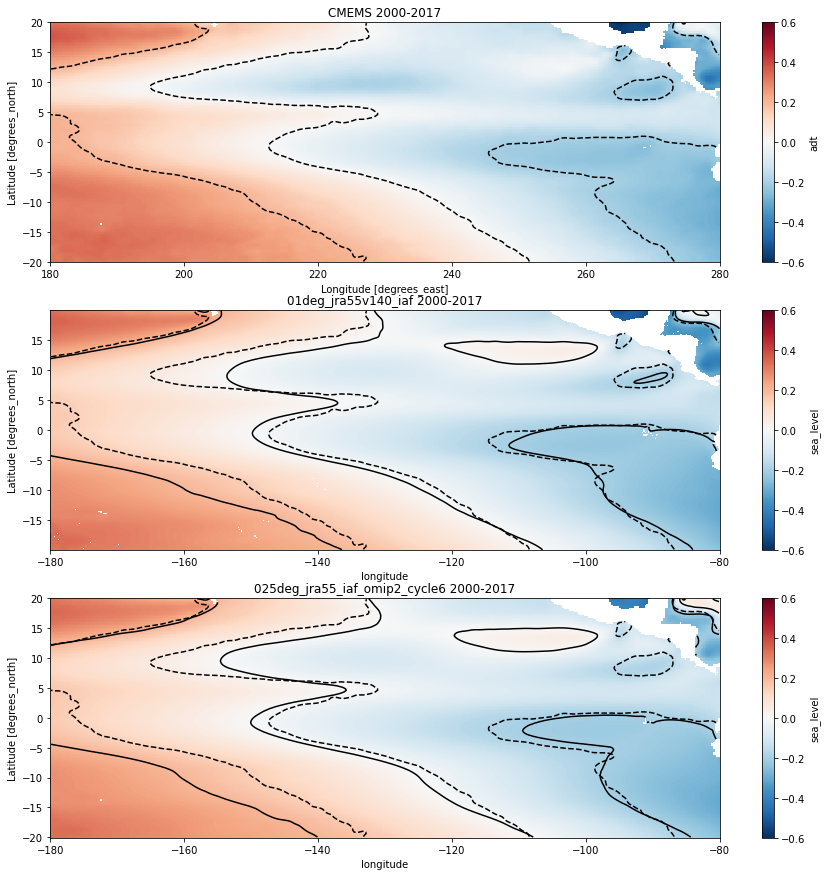

In [85]:
# Compare SSH structure to CMEMS:
lons = -180.,-80.
lats = -20., 20.
dates = '2000-01-01','2017-01-01'

ssh_obs = CMEMS.adt.sel(time=slice(dates[0],dates[1])).sel(longitude=slice(lons[0]+360.,lons[1]+360.)).sel(latitude=slice(lats[0],lats[1])).mean('time')
ssh01 = cc.querying.getvar(exp01, 'sea_level',session, frequency='1 monthly',start_time=dates[0],end_time=dates[1])
ssh01 = ssh01.sel(time=slice(dates[0],dates[1])).sel(xt_ocean=slice(lons[0],lons[1])).sel(yt_ocean=slice(lats[0],lats[1])).mean('time')
ssh025 = cc.querying.getvar(exp025, 'sea_level',session, frequency='1 monthly',start_time=dates[0],end_time=dates[1])
ssh025 = ssh025.sel(time=slice(dates[0],dates[1])).sel(xt_ocean=slice(lons[0],lons[1])).sel(yt_ocean=slice(lats[0],lats[1])).mean('time')

# subtract mean:
ssh01=ssh01-ssh01.mean('yt_ocean').mean('xt_ocean')
ssh025=ssh025-ssh025.mean('yt_ocean').mean('xt_ocean')
ssh_obs=ssh_obs-ssh_obs.mean('latitude').mean('longitude')

fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(15,15))
ssh_obs.plot(ax=axes[0],vmin=-0.6,vmax=0.6,cmap='RdBu_r')
ssh_obs.plot.contour(ax=axes[0],levels=[-0.2,0.0,0.2],colors='k',linestyles='dashed')
ssh01.plot(ax=axes[1],vmin=-0.6,vmax=0.6,cmap='RdBu_r')
ssh01.plot.contour(ax=axes[1],levels=[-0.2,0.0,0.2],colors='k',linestyles='solid')
ssh_obs['longitude'] = ssh_obs.longitude-360.
ssh_obs.plot.contour(ax=axes[1],levels=[-0.2,0.0,0.2],colors='k',linestyles='dashed')
ssh025.plot(ax=axes[2],vmin=-0.6,vmax=0.6,cmap='RdBu_r')    
ssh025.plot.contour(ax=axes[2],levels=[-0.2,0.0,0.2],colors='k',linestyles='solid')
ssh_obs.plot.contour(ax=axes[2],levels=[-0.2,0.0,0.2],colors='k',linestyles='dashed')

axes[0].set_title('CMEMS 2000-2017')
axes[1].set_title(exp01 +' 2000-2017')
axes[2].set_title(exp025 + ' 2000-2017')

plt.savefig('Spatial_SSH_bias.png',dpi=100)

# Compare vertical profiles

In [8]:
# TAO data extraction function:
obs_th = 2500 # This criteria denotes the minimum number of observations at a given depth required to include this point in the comparison.
def get_TAO(lonTAO):
    # Load temperature:
    tao_file_temp = xr.open_dataset('/g/data/ik11/observations/TAO/t0n' + lonTAO + '_dy.cdf')
    tao_temp = tao_file_temp['T_20'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))
    tao_temp = tao_temp.where(tao_temp!=1.e35)
    count = np.count_nonzero(~np.isnan(tao_temp), axis=0)
    tao_temp = tao_temp.isel(depth=count>=obs_th) # Only average if more than x observations at given depth
    
    # Load zonal velocity from ADCP data:
    tao_file_u = xr.open_dataset('/g/data/ik11/observations/TAO/adcp0n' + lonTAO + '_dy.cdf')
    tao_u = tao_file_u['u_1205'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))/100.
    tao_u = tao_u.where(abs(tao_u)<=100.)
    count = np.count_nonzero(~np.isnan(tao_u), axis=0)
    tao_u = tao_u.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth

    # Load zonal velocity from current data:
    tao_file_uc = xr.open_dataset('/g/data/ik11/observations/TAO/cur0n' + lonTAO + '_dy.cdf')
    tao_uc = tao_file_uc['U_320'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))/100.
    tao_uc = tao_uc.where(abs(tao_uc)<=100.)
    count = np.count_nonzero(~np.isnan(tao_uc), axis=0)
    tao_uc = tao_uc.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth
    
    return tao_temp, tao_u, tao_uc

# Johnson data function:
def get_Joh(lonJoh):
    joh_file = xr.open_dataset('/g/data/ik11/observations/Johnson2002/meanfit_m.cdf')
    joh_temp = joh_file['POTEMPM']
    joh_u = joh_file['UM']

    joh_temp_eq = joh_temp.sel(ZDEP1_50=slice(0,400)).sel(YLAT11_101=0., method='nearest').sel(XLON=lonJoh,method='nearest')
    joh_u_eq = joh_u.sel(ZDEP1_50=slice(0,400)).sel(YLAT11_101=0., method='nearest').sel(XLON=lonJoh,method='nearest')
    dep_joh = joh_temp_eq.ZDEP1_50
    
    return joh_temp_eq, joh_u_eq, dep_joh
    
# WOA data function:
def get_WOA(lonWOA):
    temp_WOA13_10 = cc.querying.getvar('025_KDS50', 'temp',session).mean('time').sel(GRID_Y_T=0.,method='nearest')
    woa_temp_eq = temp_WOA13_10.sel(GRID_X_T=lonWOA,method='nearest')
    
    return woa_temp_eq

distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


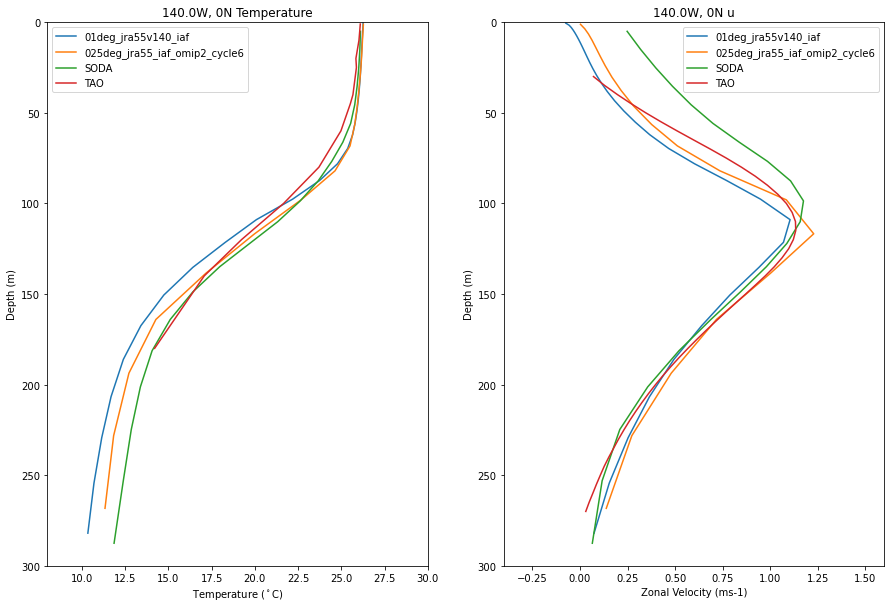

In [37]:
lon = -140.
lat = 0.
deps = 0.,300.
#dates = '2010-07-01','2010-11-15'#'2011-07-01'
dates = '2000-01-01','2006-01-01'#'2011-07-01'

u_soda = SODA.u.sel(time=slice(dates[0],dates[1])).sel(xu_ocean=lon+360.,method='nearest').sel(yu_ocean=lat,method='nearest').sel(st_ocean=slice(deps[0],deps[1])).mean('time')
u01 = cc.querying.getvar(exp01, 'u',session, frequency='1 monthly',start_time=dates[0],end_time=dates[1])
u01 = u01.sel(time=slice(dates[0],dates[1])).sel(xu_ocean=lon,method='nearest').sel(yu_ocean=lat,method='nearest').sel(st_ocean=slice(deps[0],deps[1])).mean('time')
u025 = cc.querying.getvar(exp025, 'u',session, frequency='1 monthly',start_time=dates[0],end_time=dates[1])
u025 = u025.sel(time=slice(dates[0],dates[1])).sel(xu_ocean=lon,method='nearest').sel(yu_ocean=lat,method='nearest').sel(st_ocean=slice(deps[0],deps[1])).mean('time')

temp_soda = SODA.temp.sel(time=slice(dates[0],dates[1])).sel(xt_ocean=lon+360.,method='nearest').sel(yt_ocean=lat,method='nearest').sel(st_ocean=slice(deps[0],deps[1])).mean('time')
temp01 = cc.querying.getvar(exp01, 'temp',session, frequency='1 monthly',start_time=dates[0],end_time=dates[1])
temp01 = temp01.sel(time=slice(dates[0],dates[1])).sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat,method='nearest').sel(st_ocean=slice(deps[0],deps[1])).mean('time')-273.15
temp025 = cc.querying.getvar(exp025, 'temp',session, frequency='1 monthly',start_time=dates[0],end_time=dates[1])
temp025 = temp025.sel(time=slice(dates[0],dates[1])).sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat,method='nearest').sel(st_ocean=slice(deps[0],deps[1])).mean('time')-273.15

tao_temp, tao_u, tao_uc = get_TAO('140w')
#joh_temp_eq, joh_u_eq, dep_joh = get_Joh(lons[lkey]['joh'])
# woa_temp_eq = get_WOA(lons[lkey]['woa'])

tao_temp = tao_temp.sel(time=slice(dates[0],dates[1]))
tao_u = tao_u.sel(time=slice(dates[0],dates[1]))

f,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,10),facecolor='white')
 
# Loop through and plot models:
temp01.plot(ax=axes[0],label=exp01)
temp025.plot(ax=axes[0],label=exp025)
temp_soda.plot(ax=axes[0],label='SODA')
tao_temp.mean('time').plot(ax=axes[0],label='TAO')
# woa_temp.plot(ax=axes[0],label='WOA13')

u01.plot(ax=axes[1],label=exp01)
u025.plot(ax=axes[1],label=exp025)
u_soda.plot(ax=axes[1],label='SODA')
tao_u.mean('time').plot(ax=axes[1],label='TAO')

for ax in axes:
    for obj in ax.lines:   
        newx = obj.get_ydata()
        newy = obj.get_xdata()

# set new x- and y- data for the line
        obj.set_xdata(newx)
        obj.set_ydata(newy)
        
# tao_u.plot(ax=axes[1],label='TAO')
axes[0].set_xlabel('Temperature ($^\circ$C)')
axes[0].set_ylabel('Depth (m)')
axes[0].legend()
axes[0].set_ylim([0.,300.])
axes[0].set_xlim([8.,30.])
axes[0].set_title(str(-lon) + 'W, 0N Temperature')

axes[1].set_xlabel('Zonal Velocity (ms-1)')
axes[1].set_ylabel('Depth (m)')
axes[1].legend()
axes[1].set_ylim([0.,300.])
axes[1].set_xlim([-0.4,1.6])
axes[1].set_title(str(-lon) + 'W, 0N u')

for ax in axes:
    ax.invert_yaxis()

plt.savefig('Temp_U_Profiles_140W_2000-2006.png',dpi=100)

In [ ]:
# Define longitudes
lons = {'165e': {'mod': -195.,'tao': '165e','joh': 165.,'woa': -195.},
        '140w': {'mod': -140.,'tao': '140w','joh': 220.,'woa': -140.},
        '110w': {'mod': -110.,'tao': '110w','joh': 250.,'woa': -110.}
        }

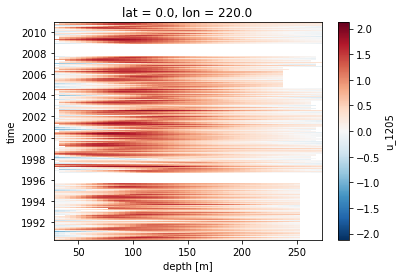

In [36]:
tao_temp, tao_u, tao_uc = get_TAO('140w')
tao_u.plot()

In [63]:
CMEMS.ugos

<xarray.DataArray 'ugos' (time: 10016, latitude: 720, longitude: 1440)>
dask.array<concatenate, shape=(10016, 720, 1440), dtype=float64, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2020-06-03
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Attributes:
    grid_mapping:   crs
    long_name:      Absolute geostrophic velocity: zonal component
    standard_name:  surface_geostrophic_eastward_sea_water_velocity
    units:          m/s